In [1]:
import gym
import matplotlib.pyplot as plt
import seaborn as sns

from fluri.sumo.single_agent_env import SingleSumoEnv
from fluri.sumo.sumo_sim import SumoKernel
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from os.path import join

GRID_SHAPE = (25, 25)

In [2]:
data = None
def init_data() -> None:
    global data
    data = {
        "action": [],
        "step": [],
        "policy": []
    }

def add_record(action, step, policy) -> None:
    global data
    data["action"].append(action[0])
    data["step"].append(step)
    data["policy"].append(policy)

In [3]:
def train() -> None:
    path = join("configs", "example")
    sim = SumoKernel(config={
        "gui": False,
        "net-file": join(path, "traffic.net.xml"),
        "route-files": join(path, "traffic.rou.xml"),
        "additional-files": join(path, "traffic.det.xml"),
        "tripinfo-output": join(path, "tripinfo.xml")
    })
    
    init_data()
    env = SingleSumoEnv(sim, grid_shape=GRID_SHAPE)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=int(2e6)) ## NOTE: Should take a while.
    return model

In [4]:
model = train()
model.policy.save("simple-model")
# model = PPO.load("simple-model")

py_loss         | -0.865      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0367     |
|    n_updates            | 19620       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 0.00777     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 222         |
|    iterations           | 1964        |
|    time_elapsed         | 18050       |
|    total_timesteps      | 4022272     |
| train/                  |             |
|    approx_kl            | 0.005240895 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.855      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0174      |
|    n_updates            | 19630       |
|    policy_gradient_loss | -0.0126     |
| 

KeyboardInterrupt: 

In [5]:
def test() -> None:
    path = join("configs", "example")
    sim = SumoKernel(config={
        "gui": True,
        "net-file": join(path, "traffic.net.xml"),
        "route-files": join(path, "traffic.rou.xml"),
        "additional-files": join(path, "traffic.det.xml"),
        "tripinfo-output": join(path, "tripinfo.xml")
    })
    
    init_data()
    env = SingleSumoEnv(sim, grid_shape=GRID_SHAPE)

    ## Random Policy.
    obs = env.reset()
    done, step = False, 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        add_record(info["taken_action"], step, "random")
        step += 1
        add_record(info["taken_action"], step, "random")

    ## RL Policy.
    obs = env.reset()
    done, step = False, 0
    while not done:
        mask = []
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action #{step} -> {action}\n")
        obs, reward, done, info = env.step(action)
        add_record(info["taken_action"], step, "RL")
        step += 1
        add_record(info["taken_action"], step, "RL")
    env.close()
    
    sns.lineplot(x="step", y="action", hue="policy", style="policy", data=data)
    plt.show()

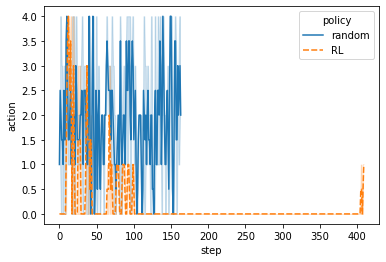

In [6]:
test()